In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')

original_corpus = pd.read_csv('data/mental_health.csv')
cleaned_corpus = pd.read_csv('data/cleaned_mhc.csv')

print("Shape of Original Corpus", original_corpus.shape)
print("Shape of Cleaned Corpus", cleaned_corpus.shape)

Shape of Original Corpus (27977, 2)
Shape of Cleaned Corpus (23240, 2)


In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Function to preprocess and evaluate models
def evaluate_logistic_regression(corpus):
    # Vectorization
    X = corpus['text']  # Assuming the text column is named 'text'
    y = corpus['label']  # Assuming the label column is named 'label'

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the TF-IDF Vectorizer
    tfidf = TfidfVectorizer(max_features=3500)
    
    # Fit the vectorizer on the training data and transform both training and testing data
    X_train_tfidf = tfidf.fit_transform(X_train).toarray()
    X_test_tfidf = tfidf.transform(X_test).toarray()

    # Define the model and parameters for Grid Search
    model = LogisticRegression(max_iter=1000)
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga', 'lbfgs']
    }

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1)
    
    # Fit the model
    start_time = time.time()
    grid_search.fit(X_train_tfidf, y_train)
    fitting_time = time.time() - start_time

    # Best model
    best_model = grid_search.best_estimator_

    # Predict on the test set
    start_time = time.time()
    y_pred = best_model.predict(X_test_tfidf)
    test_time = time.time() - start_time

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results = {
        'model': best_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fitting_time': fitting_time,
        'test_time': test_time,
        'confusion_matrix': conf_matrix
    }

    return results

# Evaluate on original corpus
results_original = evaluate_logistic_regression(original_corpus)
print("\nResults for Original Corpus:")
print(f"Test Accuracy: {results_original['accuracy']:.4f}")
print(f"Precision: {results_original['precision']:.4f}")
print(f"Recall: {results_original['recall']:.4f}")
print(f"F1 Score: {results_original['f1']:.4f}")
print(f"Training Time: {results_original['fitting_time']:.4f} seconds")
print(f"Test Time: {results_original['test_time']:.4f} seconds")
print("Confusion Matrix:\n", results_original['confusion_matrix'])

# Evaluate on cleaned corpus
results_cleaned = evaluate_logistic_regression(cleaned_corpus)
print("\nResults for Cleaned Corpus:")
print(f"Test Accuracy: {results_cleaned['accuracy']:.4f}")
print(f"Precision: {results_cleaned['precision']:.4f}")
print(f"Recall: {results_cleaned['recall']:.4f}")
print(f"F1 Score: {results_cleaned['f1']:.4f}")
print(f"Training Time: {results_cleaned['fitting_time']:.4f} seconds")
print(f"Test Time: {results_cleaned['test_time']:.4f} seconds")
print("Confusion Matrix:\n", results_cleaned['confusion_matrix'])

# The models are stored in results_original['model'] and results_cleaned['model'] for further analysis

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Results for Original Corpus:
Test Accuracy: 0.9219
Precision: 0.9278
Recall: 0.9148
F1 Score: 0.9212
Training Time: 711.9684 seconds
Test Time: 0.0260 seconds
Confusion Matrix:
 [[2603  199]
 [ 238 2556]]
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Results for Cleaned Corpus:
Test Accuracy: 0.9228
Precision: 0.9301
Recall: 0.9290
F1 Score: 0.9295
Training Time: 557.7658 seconds
Test Time: 0.0198 seconds
Confusion Matrix:
 [[1921  178]
 [ 181 2368]]


Plotting heatmap for Original Corpus model...


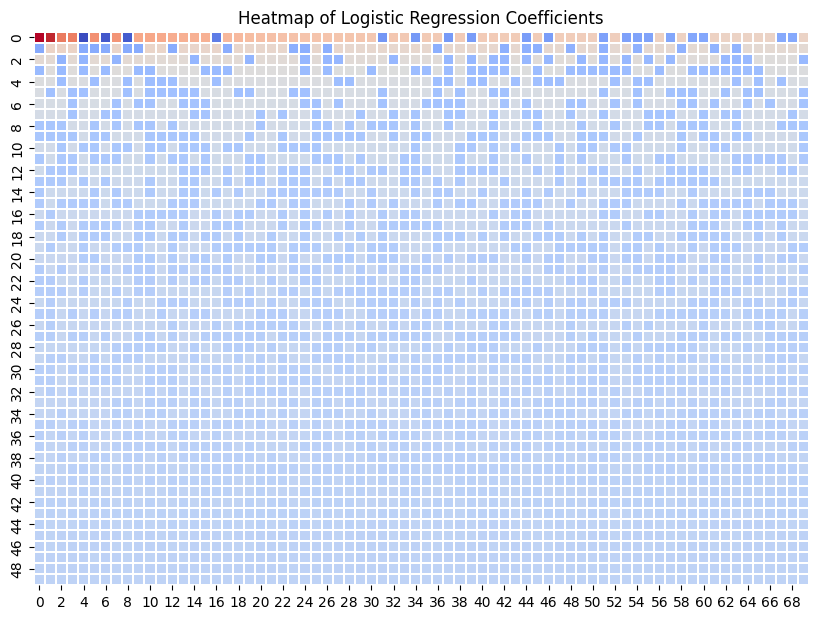

Plotting heatmap for Cleaned Corpus model...


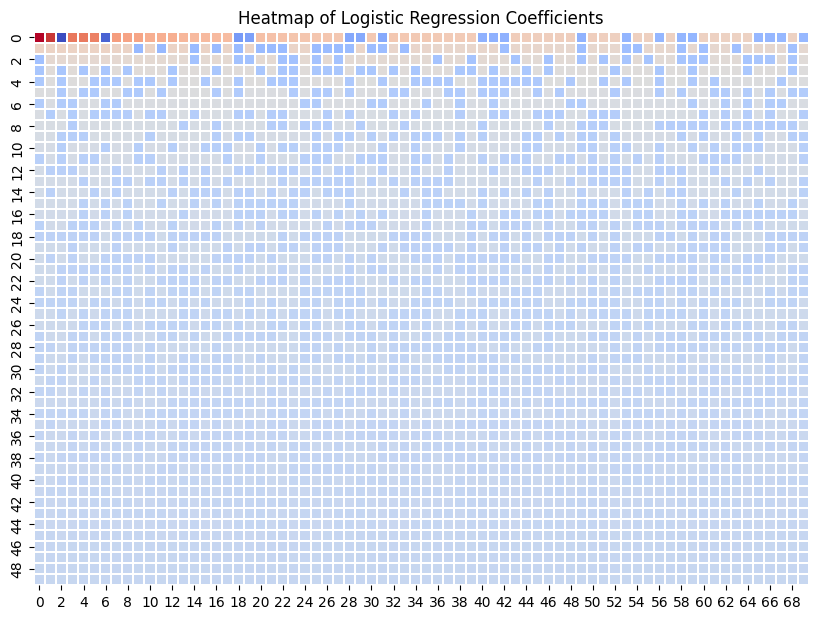

In [14]:
# Function to extract and visualize coefficients
def plot_coefficients_heatmap(corpus, model, rows=50, cols=70):
    # Vectorization
    X = corpus['text']  # Assuming the text column is named 'text'
    y = corpus['label']  # Assuming the label column is named 'label'

    # Initialize the TF-IDF Vectorizer
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tfidf = TfidfVectorizer(max_features=3500)
    
    X_tfidf = tfidf.fit_transform(X_train).toarray()

    # Get coefficients
    coefficients = model.coef_[0]  # Assuming binary classification

    # Create a DataFrame with feature names and their corresponding coefficients
    feature_names = tfidf.get_feature_names_out()
    coeff_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

    # Sort the DataFrame by absolute coefficient value
    coeff_df['abs_coefficient'] = coeff_df['coefficient'].abs()
    coeff_df = coeff_df.sort_values(by='abs_coefficient', ascending=False)

    # Ensure we have enough coefficients to reshape
    if len(coeff_df) < rows * cols:
        print(f"Warning: Not enough features to fill a {rows}x{cols} heatmap. Adjusting size.")
        rows = len(coeff_df) // cols + 1  # Adjust rows based on available features

    # Create a heatmap with specified dimensions
    coeff_matrix = coeff_df['coefficient'].values[:rows * cols].reshape(rows, cols)

    # Set up the figure and axis for the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(coeff_matrix, cmap='coolwarm', cbar=False, square=True, linewidths=0.1)
    plt.title('Heatmap of Logistic Regression Coefficients')
    plt.show()

# Plot heatmap for original corpus model
print("Plotting heatmap for Original Corpus model...")
plot_coefficients_heatmap(original_corpus, results_original['model'])

# Plot heatmap for cleaned corpus model
print("Plotting heatmap for Cleaned Corpus model...")
plot_coefficients_heatmap(cleaned_corpus, results_cleaned['model'])

In [15]:
# Function to print top and bottom coefficients
def print_top_bottom_coefficients(corpus, model):
    # Vectorization
    X = corpus['text']  # Assuming the text column is named 'text'
    y = corpus['label']  # Assuming the label column is named 'label'
    
    # Initialize the TF-IDF Vectorizer
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tfidf = TfidfVectorizer(max_features=3500)
    
    X_tfidf = tfidf.fit_transform(X_train).toarray()

    # Get coefficients
    coefficients = model.coef_[0]  # Assuming binary classification
    feature_names = tfidf.get_feature_names_out()

    # Create a DataFrame with feature names and their corresponding coefficients
    coeff_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

    # Sort the DataFrame by coefficient value
    coeff_df_sorted = coeff_df.sort_values(by='coefficient', ascending=False)

    # Top 20 largest coefficients
    top_20 = coeff_df_sorted.head(25)
    print("Top 25 Largest Coefficients:")
    print(top_20[['feature', 'coefficient']])

    # Bottom 10 smallest coefficients
    bottom_10 = coeff_df_sorted.tail(25)
    print("\nBottom 25 Smallest Coefficients:")
    print(bottom_10[['feature', 'coefficient']])

# Print top and bottom coefficients for original corpus model
print("Top and Bottom Coefficients for Original Corpus model:")
print_top_bottom_coefficients(original_corpus, results_original['model'])

# Print top and bottom coefficients for cleaned corpus model
print("\nTop and Bottom Coefficients for Cleaned Corpus model:")
print_top_bottom_coefficients(cleaned_corpus, results_cleaned['model'])

Top and Bottom Coefficients for Original Corpus model:
Top 25 Largest Coefficients:
         feature  coefficient
2475     redflag     7.969553
1689        kill     7.536213
809          die     5.588663
2968    suicidal     5.469409
1777        life     4.948192
454       cannot     4.787306
774   depression     4.204547
1692     killing     4.186953
2024      myself     4.076291
973          end     3.991304
142      anymore     3.885025
91         alive     3.827345
2256       pills     3.808608
1806      living     3.589832
1125        feel     3.516377
3339        want     3.356489
748        death     3.251419
3198       tried     3.190286
2969     suicide     3.129227
3450       worse     3.079570
2287       point     3.049847
3107    thoughts     3.047523
2171        pain     3.030446
1900          me     3.011960
97         alone     2.995137

Bottom 25 Smallest Coefficients:
        feature  coefficient
1342      great    -2.070276
714        cute    -2.079500
3027    teacher

In [16]:
# Function to print the hyperparameters of the models
def print_model_hyperparameters(grid_search_result):
    # Extract the best model from grid search
    best_model = grid_search_result['model']
    
    # Print the hyperparameters
    print("Model Hyperparameters:")
    for param, value in best_model.get_params().items():
        print(f"{param}: {value}")

# Print hyperparameters for the original corpus model
print("Hyperparameters for Original Corpus model:")
print_model_hyperparameters(results_original)

# Print hyperparameters for the cleaned corpus model
print("\nHyperparameters for Cleaned Corpus model:")
print_model_hyperparameters(results_cleaned)

Hyperparameters for Original Corpus model:
Model Hyperparameters:
C: 1
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 1000
multi_class: deprecated
n_jobs: None
penalty: l2
random_state: None
solver: saga
tol: 0.0001
verbose: 0
warm_start: False

Hyperparameters for Cleaned Corpus model:
Model Hyperparameters:
C: 1
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 1000
multi_class: deprecated
n_jobs: None
penalty: l2
random_state: None
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False
